In [1]:
from SPCCT_4D import Sample, Timepoint, Viewer
# Calling the bunny army
s1 = Sample(1)
s2 = Sample(2)
s3 = Sample(3)
s4 = Sample(4)

c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\SPCCT_4D.py:25: SyntaxWarning: invalid escape sequence '\c'
  base_path = f"D:\copyRaw\Rabbit_AGUIX_{rabbit_id}"


Available directories:
0: 2021_01_25.4531.300.2024_03_17.AGUIX_Rabbit_26201_h00000
1: 2021_01_25.4531.400.2024_03_15.AGUIX_Rabbit_26201_f00001
2: 2021_01_25.4531.500.2024_03_15.AGUIX_Rabbit_26201_f00002
3: 2021_01_25.4531.600.2024_03_15.AGUIX_Rabbit_26201_f00003
4: 2021_01_25.4531.700.2024_03_15.AGUIX_Rabbit_26201_f00004
Conventional file 1 total DICOM files found: 480
Spectral\k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral\k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral\k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral\k_gadolinium file 4 total DICOM files found: 480
Conventional file 5 total DICOM files found: 480
Spectral\k_gadolinium file 5 total DICOM files found: 480
Available directories:
0: 2021_01_25.4533.300.2024_03_17.AGUIX_Rabbit_26608_e00000
1: 2021_01_25.4533.400.2024_03_15.AGUIX_Rabbit_26608_c00001

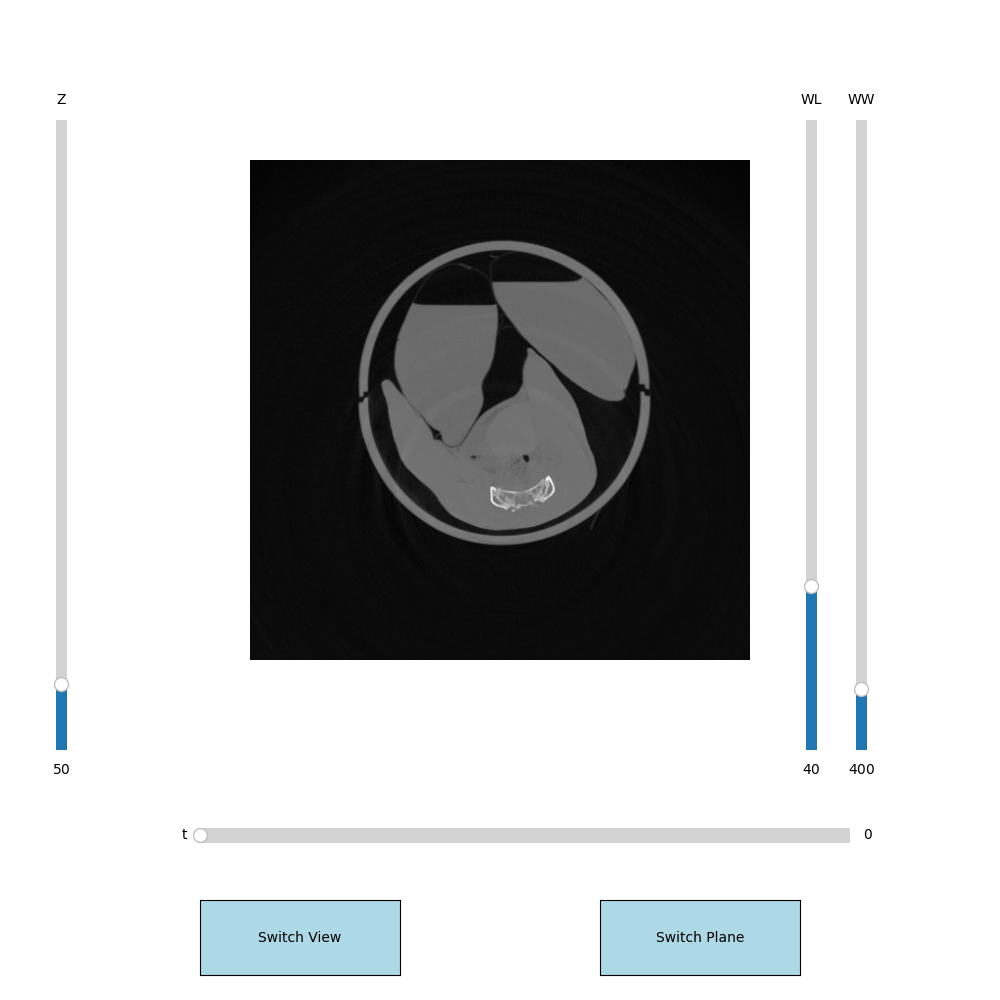

In [18]:
%matplotlib widget
viewS4 = Viewer(s4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector, Button
from matplotlib.path import Path
from skimage.morphology import binary_dilation, disk
import pandas as pd
import pydicom
from pydicom.dataset import FileDataset
import datetime

class vesselDoameter:
    def __init__(self, viewer, sample):
        self.viewer = viewer
        self.viewer.__init__(sample)
        self.sample = sample
        self.data = pd.DataFrame(columns=["Signal_HU", "Noise_HU", "CNR_HU", "Signal_Kedge", "Noise_Kedge", "CNR_Kedge"])
        self.masks = []
        self.mask_overlay = None
        
        # Set up the button for showing/hiding the mask
        self.mask_button = Button(plt.axes([0.4, 0.225, 0.2, 0.075]), 'Toggle Mask', color='lightblue', hovercolor='0.975')
        self.mask_button.on_clicked(self.toggleMask)
        
        # Use LassoSelector on the viewer's current axes
        self.instruction_text = None
        self.lasso = LassoSelector(viewer.ax, onselect=self.onselect, useblit=True)
        self.verts = None
        # Connect the key press event
        self.cid = self.viewer.fig.canvas.mpl_connect('key_press_event', self.on_key_press)


    def onselect(self, verts):
        self.verts = verts
        # Remove any existing instruction text
        if self.instruction_text is not None:
            self.instruction_text.remove()
        # Add new instruction text
        self.instruction_text = self.viewer.ax.text(0.5, 0.01, "Press 'Enter' to confirm, 'Esc' to cancel.",
                                                     transform=self.viewer.ax.transAxes,
                                                     horizontalalignment='center',
                                                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.draw()  # Make sure the drawing is updated

    def on_key_press(self, event):
        if event.key == 'enter' and self.verts is not None:
            
            # Remove instruction text and lasso selector after choice is confirmed
            if self.instruction_text is not None:
                self.instruction_text.remove()
                self.instruction_text = None  # Reset the reference
            
            plt.draw()  # Update the drawing to reflect changes
            self.lasso.active = False
            self.process_selection(self.verts)
            # Disconnect keypress as well
            self.viewer.fig.canvas.mpl_disconnect(self.cid)

        elif event.key == 'escape':
            if self.instruction_text is not None:
                self.instruction_text.set_text("Selection cancelled. Make a new selection.")
                plt.draw()

    def vesselMeasurements(self, sample, mask, washer_disk):

        measurements = []

        for i in range(len(sample.acquisition)):
            conventional = sample.acquisition[i].conventional[:, :, self.viewer.slice_slider.val]
            kedge = sample.acquisition[i].kedge[:, :, self.viewer.slice_slider.val]

            # Calculate metrics for conventional and k-edge images
            signal_HU, noise_HU = np.mean(conventional[mask]), np.mean(conventional[washer_disk])
            CNR_HU = (signal_HU - noise_HU) / np.std(conventional[washer_disk])
        
            signal_Kedge, noise_Kedge = np.mean(kedge[mask]), np.mean(kedge[washer_disk])
            CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_disk])
        
        # Append metrics to the list
        measurements.append([signal_HU, noise_HU, CNR_HU, signal_Kedge, noise_Kedge, CNR_Kedge])
    
        # Convert measurements list to a DataFrame and append it to self.data
        new_data = pd.DataFrame(measurements, columns=self.data.columns)
        self.data = pd.concat([self.data, new_data], ignore_index=True)
            
    def process_selection(self, verts):
        print("Processing the selection...")

        mask_file = input("Name the file to store the mask in. feature_sample_date")
        np.save(mask_file+".npy", self.mask[0])

        # Create a Path object from the lasso vertices
        lasso_path = Path(verts)

        # Generate a mask for the selected region and an external washer mask for additional measurements
        nx, ny = self.viewer.image_display.get_array().shape[1], self.viewer.image_display.get_array().shape[0]
        x, y = np.meshgrid(np.arange(nx), np.arange(ny))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T
        mask = lasso_path.contains_points(points).reshape((ny,nx))

        dilated_mask = binary_dilation(mask, disk(5))
        washer_disk = dilated_mask & ~mask
        
            # Create an overlay image where the selected region and washer are highlighted
        overlay = np.zeros((*mask.shape, 4))  # Create an RGBA image for overlay
        overlay[mask, :] = [1, 0, 0, 0.5]  # Red with transparency for the selected region
        overlay[washer_disk, :] = [0, 0, 1, 0.5]  # Blue with transparency for the washer region

        if not self.masks:  # If masks list is empty
            self.masks.append(overlay)  # Store the first overlay
        else:
            self.masks[0] = overlay  # Update the existing overlay
    
        # Display the overlay on top of the original image
        #self.viewer.ax.imshow(overlay, extent=self.viewer.image_display.get_extent())

        print(self.viewer.slice_slider.val)

        #Loop through all images and calculate values
        self.vesselMeasurements(self.sample, mask, washer_disk)
        df = input("Please name the csv with measurements: feature_sample_date")
        self.data.to_csv(df+".csv", index = False)
    
        # Force a redraw of the figure to update the display
        self.viewer.fig.canvas.draw_idle()
        
    def toggleMask(self, event):
        
        if self.mask_overlay:  # Check if overlay exists
            self.mask_overlay.remove()  # Remove existing overlay
            self.mask_overlay = None
        else:
            # Recreate the overlay if it's been removed
            self.showMask()
        self.viewer.fig.canvas.draw_idle()

    def showMask(self):
        if not self.mask_overlay:  # Only create the overlay if it doesn't exist
            self.mask_overlay = self.viewer.ax.imshow(self.masks[0], extent=self.viewer.image_display.get_extent())
    

        


In [ ]:
vesselDoameter(viewS4, s4)

In [ ]:
getattr(s4.acquisition[0], "kedge")[:, :, 249]

s4.acquisition[0].conventional[:,:,249]

array([[-1089., -1073., -1098., ..., -1104., -1097., -1097.],
       [-1101., -1071., -1083., ..., -1092., -1085., -1110.],
       [-1085., -1087., -1081., ..., -1081., -1095., -1108.],
       ...,
       [ -985.,  -973.,  -972., ...,  -989., -1007., -1005.],
       [ -986.,  -989.,  -970., ...,  -991., -1004.,  -977.],
       [ -982.,  -991.,  -983., ...,  -989.,  -991.,  -976.]])